# Introducing uncertainty
Introducing the unknown parameter $\varepsilon$ into the PDE:

$ -\varepsilon u_{xx} -\varepsilon u_{yy} = -2\pi^2 \sin{(\pi x)} \sin{(\pi y)} $ for $1 \leq \varepsilon \leq 2$

Can take random samples of $\varepsilon$ and solve for each sample, then take the mean and variance of the solutions. Solve using similarity transformations and calculating the eigenvalues explicitly. 

Time:  0.013512134552001953
Sample average:  1.530346819926531
Error inf:  0.009150420587580532
Error sq:  0.004669789946070374
Time:  13.008287906646729
Sample average:  1.499993855222448
Error inf:  0.026522921910494324
Error sq:  0.01353560449954983


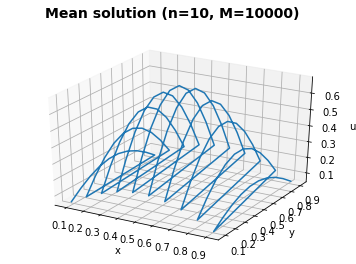

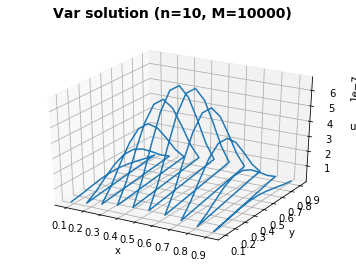

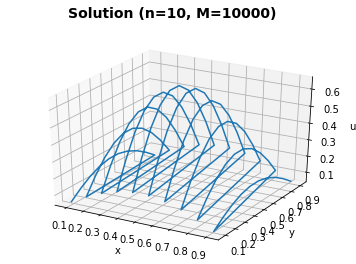

In [26]:
#Import necessary modules
import numpy as np
from scipy.sparse import diags
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import time
import random

#Define parameters
n = 10
h = 1/(n+1) #step size

#Define x and y as arrays between 0 and 1 with n evenly spaced points (internal nodes)
x = np.linspace(h, 1-h, n)
y = np.linspace(h, 1-h, n)

#Create internal mesh (excludes boundaries)
X, Y = np.meshgrid(x, y, indexing='ij')

#Define F 
F = 2 * np.pi**2 * np.sin(np.pi*X) * np.sin(np.pi*Y)
        
def monteCarlo(r1, r2, M):

    #Define mean, variance and solutions as zero matrices
    mean_sol = np.zeros([n,n])
    var_sol = np.zeros([n,n])
    sols = np.zeros([M,n,n])
    
    eps_arr = []
    
    start_time = time.time()
    
    for i in range(0, M): 
        eps = random.uniform(r1, r2) #Generate random eps in range(r1,r2)
        eps_arr.append(eps)
        U = solvePDE(eps) #Solve PDE using generated eps
        sols[i] = U
        mean_sol += U
        
    mean_sol = mean_sol/M #Divide by number of samples to get the mean solution
    
    #Calculate variance
    for i in range(0, M):
        var_sol += ((sols[i] - mean_sol)**2)
        var_sol = var_sol/(M-1)
        
    end_time = time.time()
    T = end_time - start_time
    
    print('Time: ', T)
        
    #Plot solution
    plt.figure(0)
    plt.suptitle('Mean solution (n=' + str(n) + ', M=' + str(M) + ')', fontsize=14, fontweight='bold')
    ax = plt.axes(projection='3d')
    xline = np.reshape(X, -1)
    yline = np.reshape(Y, -1)
    zline = np.reshape(mean_sol, -1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.plot3D(xline, yline, zline)
    
    plt.figure(1)
    plt.suptitle('Var solution (n=' + str(n) + ', M=' + str(M) + ')', fontsize=14, fontweight='bold')
    ax = plt.axes(projection='3d')
    xline = np.reshape(X, -1)
    yline = np.reshape(Y, -1)
    zline = np.reshape(var_sol, -1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.plot3D(xline, yline, zline)
    
    #Take average of epsilon and solve the PDE using this value for comparison
    eps_avg = 0
    for i in range(0, len(eps_arr)):
        eps_avg += eps_arr[i]
    eps_avg = eps_avg/len(eps_arr)
    print('Sample average: ', eps_avg)
    
    #Plot solution
    U = solvePDE(eps_avg)
    plt.figure(2)
    plt.suptitle('Solution (n=' + str(n) + ', M=' + str(M) + ')', fontsize=14, fontweight='bold')
    ax = plt.axes(projection='3d')
    xline = np.reshape(X, -1)
    yline = np.reshape(Y, -1)
    zline = np.reshape(U, -1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    ax.plot3D(xline, yline, zline)
    
    #Compute error at each node
    error_inf = 0
    error_sq = 0
    for i in range(0,n):
        for j in range(0,n):
            error_sq += np.absolute(U[i][j] - mean_sol[i][j])**2
            if np.absolute(U[i][j] - mean_sol[i][j]) > error_inf:
                error_inf = np.absolute(U[i][j] - mean_sol[i][j])

    error_sq = (error_sq * h**2)**0.5
    print('Error inf: ', error_inf)
    print('Error sq: ', error_sq)
    
    

def solvePDE(eps):
    ''' Solve given PDE using similarity transformations and calculating eigenvalues explicitly
        Input: eps - value of epsilon in PDE
        Output: U - computed solution of PDE
    '''
    #Define tridiagonal matrix T
    diagonals = [[-2],[1],[1]]
    T = np.multiply(-eps/h**2, diags(diagonals, [0, -1, 1], shape=(n, n)).toarray())

    #Calculate eigenvalues and eigenvectors
    eigvals = np.empty(n)
    eigvecs = np.empty([n,n])
    for i in range(0,n):
        eigvals[i] = (T[0][0] - T[0][0]*np.cos((i+1)*np.pi/(n+1)))
        for j in range(0,n):
            eigvecs[i][j] = np.sqrt(2/(n+1))*np.sin(((i+1)*(j+1)*np.pi)/(n+1))

    #Set eigenvalues as diagonal matrix
    diag = diags(eigvals, 0, shape=(n, n)).toarray()

    #Set basis matrix M, with columns as the eigenvectors
    P = eigvecs

    #Define F_hat = P^-1 * F * P
    F_hat = np.matmul(np.matmul(np.linalg.inv(P),F),P)

    #Calculate U_hat, u_hat(i,j) = f(i,j) / eigval(i) + eigval(j)
    U_hat = np.empty([n,n])
    for i in range(0,n):
        for j in range(0,n):
            if (eigvals[i]!=0 or eigvals[j]!=0):
                U_hat[i][j] = F_hat[i][j] / (eigvals[i]+eigvals[j])
            else:
                U_hat[i][j] = 0

    #Calculate solution U = M * U^hat * M^-1
    U = np.matmul(np.matmul(P,U_hat),np.linalg.inv(P))
    
    return U
    

monteCarlo(1,2,10)
monteCarlo(1,2,10000)





